# Tutorial for Multiclass Training

At this tutorial, we will train the ResNet on the esc50 data which is a mutlticlass dataset and evaluate our model by on a 20% split of the data. 

# Step 0) Install dependencies and start python virtual environment (see the main README.md)

```bash
poetry install
poetry shell
```

# Step1) Import esc50 Dataset



In [1]:
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.transforms import  BirdSetTransformsWrapper, PreprocessingConfig
from torchaudio.transforms import MelScale, Spectrogram
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.esc50_datamodule import ESC50DataModule


transforms = BirdSetTransformsWrapper(sampling_rate=44100, decoding=None, model_type='vision', task="multiclass", preprocessing=PreprocessingConfig(spectrogram_conversion=Spectrogram(n_fft=400, hop_length=200, power=2.0),melscale_conversion=MelScale(n_mels=128, sample_rate=44100, n_stft=201)))
dataset_config = DatasetConfig(
    data_dir="../../../data_birdset",
    dataset_name="esc50",
    hf_path="ashraq/esc50",
    hf_name="default",
    seed=1,
    n_workers=1,
    val_split=0.2,
    task="multiclass",
    subset=None,
    sampling_rate=44100,
)
dm = ESC50DataModule(dataset=dataset_config, transforms=transforms)

# Step2) Prepare Data

In [2]:
dm.prepare_data()
print('Number of samples in the training set: ', dm.len_trainset)
print('Number of samples in the validation set: ', len(dm.val_dataset))
print('Number of samples in the test set: ', len(dm.test_dataset))
print('Number of classes: ',dm.num_classes)
dm.setup(stage='fit')
train_dataloader = dm.train_dataloader
test_loader = dm.test_dataloader()

Repo card metadata block was not found. Setting CardData to empty.


Number of samples in the training set:  1280


AttributeError: 'ESC50DataModule' object has no attribute 'len_valset'

# Read and plot Spectrogram of one sample of data

Batch keys:  dict_keys(['input_values', 'labels'])
Shape of input_values tensor:  torch.Size([32, 1, 128, 1024])
Shape of label tensor:  torch.Size([32])


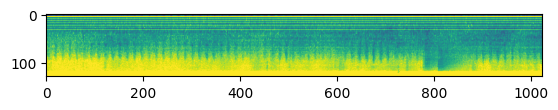

In [57]:
from matplotlib import pyplot as plt

# get first batch
batch = next(iter(train_dataloader()))
print('Batch keys: ', batch.keys())
print('Shape of input_values tensor: ', batch['input_values'].shape)
print('Shape of label tensor: ', batch['labels'].shape)

spectorgram = batch['input_values'][0]

plt.imshow(spectorgram.squeeze().numpy())


# Step3) Prepare trainer

In this tutorial we train our model with 20 epochs to show how it works and make a visible pipline . For having reasonable results the model should be traind by more epochs and with additional external data. 

In [58]:
#from train_loader = dm.train_dataloader() import Trainer
from lightning import Trainer
min_epochs = 1
max_epochs = 20
trainer = Trainer(min_epochs=min_epochs, max_epochs=max_epochs, accelerator="gpu", devices=[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Step4) Prepare your model

In [59]:
from birdset.configs.module_configs import MulticlassMetricsConfig
from birdset.modules.models.resnet import ResNetClassifier
from birdset.modules.base_module import BaseModule,NetworkConfig
from torch.nn import CrossEntropyLoss

NetworkConfig=NetworkConfig(        
        model=ResNetClassifier(baseline_architecture="resnet50",num_classes =50,num_channels=1),
        model_name ="resnet50",
        model_type="vision",
        torch_compile= False,
        sample_rate=32000,
        normalize_waveform=False,
        normalize_spectrogram=True)


model = BaseModule(
    network=NetworkConfig,
    loss=CrossEntropyLoss(),
    #label_counts= 50,
    len_trainset=dm.len_trainset,
    task=dm.task,
    batch_size=dm.train_batch_size,
    num_epochs=max_epochs,
    metrics=MulticlassMetricsConfig(num_labels=50)
    )


        # define optimizer and scheduler

In [60]:
model

BaseModule(
  (loss): CrossEntropyLoss()
  (model): ResNetClassifier(
    (model): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

# Step5) Initializing your model with esc50 data

In [61]:
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                  | Type               | Params
-------------------------------------------------------------
0 | loss                  | CrossEntropyLoss   | 0     
1 | model                 | ResNetClassifier   | 23.6 M
2 | train_metric          | MulticlassAccuracy | 0     
3 | valid_metric          | MulticlassAccuracy | 0     
4 | test_metric           | MulticlassAccuracy | 0     
5 | valid_metric_best     | MaxMetric          | 0     
6 | valid_add_metrics     | MetricCollection   | 0     
7 | test_add_metrics      | MetricCollection   | 0     
8 | test_complete_metri

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


# Step6) Evaluate your model with your test data

In [62]:
trainer.test(model=model,datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test/CrossEntropyLoss   │     2.881437063217163     │
│          test/F1          │    0.24250000715255737    │
│  test/MulticlassAccuracy  │    0.24250000715255737    │
└───────────────────────────┴───────────────────────────┘

[{'test/CrossEntropyLoss': 2.881437063217163,
  'test/MulticlassAccuracy': 0.24250000715255737,
  'test/F1': 0.24250000715255737}]